# Random Forest (Assignment 3)

## Student: Rodolfo Lerma

In this lab assignment, you will implement a simplified version of Random Forest classifier and practice how to use and fine-tune Random Forest, Extra Trees, and Gradient Boosted Trees. You will then compare the model performance of various classifiers on internet ad dataset.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features. 

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [2]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', error_bad_lines=False)

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(internetAd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


In [4]:
internetAd.head(20)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [5]:
internetAd.shape

(3279, 1559)

It is possible to notice the high number of features in the dataset. This might be a problem later on (curse of dimensionality).

## Question 1: Prepare and impute missing values with the median (missing values for this dataset are \?, nonad. ad.)

In [6]:
options = ["?"," ?" ," ? ","   ?", "     ?", "      ?","       ?","     ?  ","     ?   "]
for i in options:
    internetAd.replace(i, np.nan, inplace=True)

In [7]:
#Convert values to numeric
sample_columns = ['height', 'width', 'aratio', 'local']
for i in sample_columns:
    internetAd[i] = pd.to_numeric(internetAd[i]) 

In [8]:
internetAd.dtypes

height                       float64
width                        float64
aratio                       float64
local                        float64
url*images+buttons             int64
url*likesbooks.com             int64
url*www.slake.com              int64
url*hydrogeologist             int64
url*oso                        int64
url*media                      int64
url*peace+images               int64
url*blipverts                  int64
url*tkaine+kats                int64
url*labyrinth                  int64
url*advertising+blipverts      int64
url*images+oso                 int64
url*area51+corridor            int64
url*ran+gifs                   int64
url*express-scripts.com        int64
url*off                        int64
url*cnet                       int64
url*time+1998                  int64
url*josefina3                  int64
url*truluck.com                int64
url*clawnext+gif               int64
url*autopen.com                int64
url*tvgen.com                  int64
u

In [9]:
#Replacing ad. and nonad.
internetAd.replace(to_replace = ['ad.','nonad.'], value = [1,0], inplace = True)

In [10]:
internetAd.head(15)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59.0,460.0,7.7966,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60.0,234.0,3.9000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


It is possibe to see that now instead of "?" we have missing values and instead of `ad.` or `nonad.` we have `1` or `0`.

In [11]:
internetAd['height'].isnull().sum()

903

In [12]:
column_names = internetAd.columns.tolist()
columns_with_null = []
for i in column_names:
    x = internetAd[i].isnull().sum()
    if x > 0:
        columns_with_null.append(i)
    else:
        pass        

In [13]:
columns_with_null

['height', 'width', 'aratio', 'local']

In [14]:
for i in columns_with_null:
    internetAd[i].fillna(internetAd[i].median(), inplace=True)

In [15]:
internetAd.head(15)

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125.0,125.0,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.0,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,59.0,460.0,7.7966,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,60.0,234.0,3.9000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
internetAd[sample_columns].describe()

,height,width,aratio,local
count,3279.000000,3279.000000,3279.000000,3279.000000
mean,60.435804,142.885026,3.409648,0.768222
std,47.064669,112.564585,5.199722,0.422032
min,1.000000,1.000000,0.001500,0.000000
25%,32.500000,90.000000,1.279400,1.000000
50%,51.000000,110.000000,2.102000,1.000000
75%,61.000000,144.000000,3.900000,1.000000
max,640.000000,640.000000,60.000000,1.000000


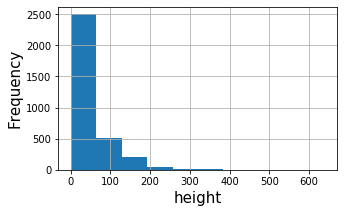

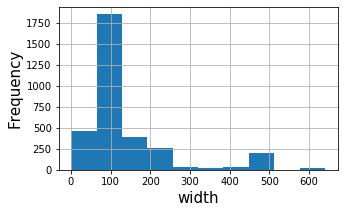

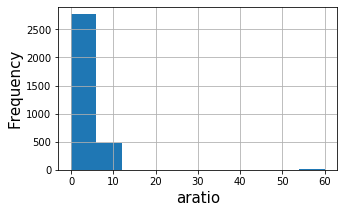

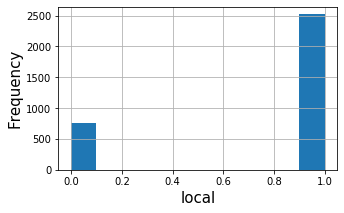

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def hist_plot(df,a):
    df[a].hist(figsize = (5,3))
    plt.xlabel(a, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.grid(True)
    plt.show()

for i in sample_columns:
    hist_plot(internetAd, i)

### Target Variable

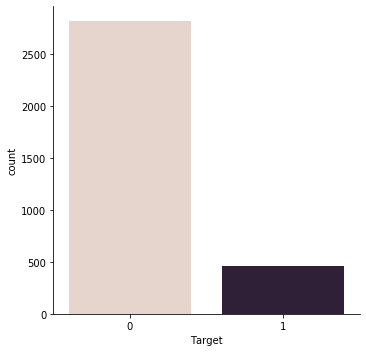

In [18]:
import seaborn as sns
sns.catplot(x="Target", kind="count", palette="ch:.1", data=internetAd)

Looking at the distribution of the `Target` column, we can see there is a class imbalance present.

## Question 2: Split dataset into training and test set

As it is possible to notice there is a wide variation across the different features. Therefore, I will normalize the features using MinMaxScalar method.

Also the dataset will be split into training and testing. The testing portion will not be touch but until the final model is decided/selected.

In [19]:
from sklearn.model_selection import train_test_split

columns_no_target = internetAd.columns.to_list()
columns_no_target.remove('Target')

X = internetAd[columns_no_target]
y = internetAd['Target']

X_train_original, X_test_final, y_train_original, y_test_final = train_test_split(X, y, test_size=0.2, random_state=42)

### A further split is used to obtain the `train` & `validation` set.

#### Class Imbalance

This also could have been done in the model itself, but as a way to standarize how this is applied it was decided to do it here.

In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
variables_res, label_res = sm.fit_resample(X_train_original, y_train_original)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(variables_res, label_res, test_size=0.2, random_state=42)

## Question 3: Train and evaluate a randomeforrest classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [23]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

rf_base = RandomForestClassifier()

dtc_grid = GridSearchCV(estimator = rf_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
dtc_grid.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [24]:
y = dtc_grid.best_params_
y

{'max_depth': 4, 'min_samples_split': 0.05}

In [25]:
# make predictions with the trained random forest
test_z = dtc_grid.predict(X_test)
test_z_prob = dtc_grid.predict_proba(X_test)

In [26]:
def performance_values(X_test, y_test, trained_model):
    
    #Libraries
    #import sklearn.metrics
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
    
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    probs = trained_model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    return (fpr, tpr, accuracy, roc_auc)

In [27]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [28]:
fpr, tpr, rf_acc, roc_auc = performance_values(X_test, y_test, dtc_grid)
print("Accuracy: {}".format(rf_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8717105263157895
AUC: 0.9432841605503476


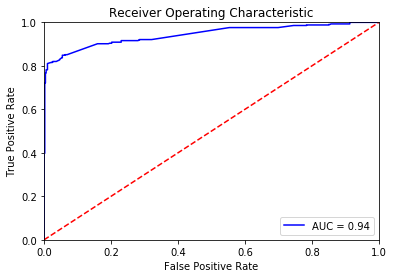

In [29]:
ROC_curve(fpr,tpr,roc_auc)

## Question 4: Train and evaluate a ExtraTrees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [30]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

et_base = ExtraTreesClassifier()

et_grid = GridSearchCV(estimator = et_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
et_grid.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [31]:
z = et_grid.best_params_
z

{'max_depth': 4, 'min_samples_split': 0.05}

In [32]:
# make predictions with the trained random forest
test_et = et_grid.predict(X_test)
test_et_prob = et_grid.predict_proba(X_test)

In [33]:
fpr, tpr, et_acc, roc_auc = performance_values(X_test, y_test, et_grid)
print("Accuracy: {}".format(et_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8201754385964912
AUC: 0.9353196230894073


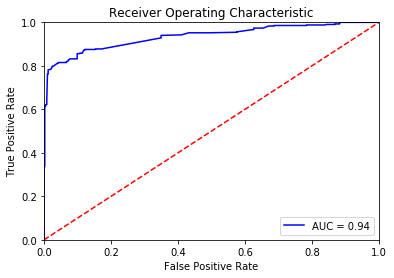

In [34]:
ROC_curve(fpr,tpr,roc_auc)

## Question 5: Train and evaluate a Gradient Boosted Trees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [35]:
parameters = {"max_depth": [2, 4],
              "min_samples_split": [0.05, 0.1, 0.2]}

gbt_base = ExtraTreesClassifier()

gbt_grid = GridSearchCV(estimator = gbt_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
gbt_grid.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2]},
             verbose=2)

In [36]:
w = gbt_grid.best_params_
w

{'max_depth': 4, 'min_samples_split': 0.05}

In [37]:
# make predictions with the trained random forest
test_gbt = gbt_grid.predict(X_test)
test_gbt_prob = gbt_grid.predict_proba(X_test)

In [38]:
fpr, tpr, gbt_acc, roc_auc = performance_values(X_test, y_test, gbt_grid)
print("Accuracy: {}".format(gbt_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.8234649122807017
AUC: 0.938982147615241


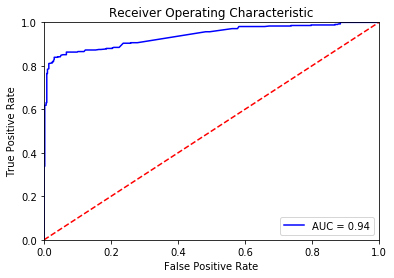

In [39]:
ROC_curve(fpr,tpr,roc_auc)

## Performance of Final Model

After looking at the results the best model was the Random Forest one. Using that model we will obtain the final performance on the unseen data.

In [41]:
test_final = dtc_grid.predict(X_test_final)
test_final_prob = dtc_grid.predict_proba(X_test_final)

In [42]:
fpr, tpr, final_acc, roc_auc = performance_values(X_test_final, y_test_final, dtc_grid)
print("Accuracy: {}".format(final_acc))
print("AUC: {}".format(roc_auc))

Accuracy: 0.9466463414634146
AUC: 0.9549507995079951


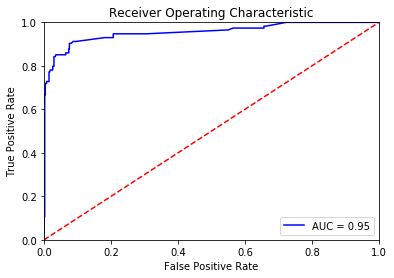

In [43]:
ROC_curve(fpr,tpr,roc_auc)

As it is possible to notice the model generalized very well as the performance of the test (final) model is actually higher than the performance of the training model. The data used for the final testing was unseen by the model.

## [Bonus] Question 6: Which algorithm performed better and why?


In [44]:
print(" Random Forest Accuracy: {}".format(rf_acc))
print(" ExtraTrees Accuracy: {}".format(et_acc))
print(" Gradient Boosted Trees Accuracy: {}".format(gbt_acc))

 Random Forest Accuracy: 0.8717105263157895
 ExtraTrees Accuracy: 0.8201754385964912
 Gradient Boosted Trees Accuracy: 0.8234649122807017


In this particular example and based on the performance values seen above, **Random Forest** seems to performe better than the other 2 models.

In this particular case the 3 models have a similar performance, Random Forest seemed to be slightly better (more statistical analysis would be needed to prove if it is significant or falls under the typical variation).

## Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 

Decision trees are widely used in the industry for their interpretability, but this usually comes at a cost, typically the performance of such models and that is where bagging/boosting comes as a solution to this problem. 

This assignment was pretty interesting as I got the opportunity to explore some of the well-known bagging and boosting machine learning models and also use one of the many options to search and select the best hyper parameters to optimize the performance of such models.


During this particular assignment some situations were highlighted, such as:
-	The class imbalance that was present on the `Target` variable. This problem can be solve by multiple approaches, the most common ones are: to use the over sampling approach to get the same number of cases for each particular response and train the model with such dataset, or the other approach is to deal with this situation in the model itself as some machine learning models has the option to balance the classes as a hyper parameter that can be activated.
-	In the case of Tree Based models usually is not needed to normalize the data. In this particular assignment we saw that the four columns with numerical data (`height`, `width`, `aratio` & `local`) had pretty different numbers (different scales). If we were working with a regression problem or other types of classifiers, normalizing such columns would be either a required pre-processing step or a really good way to minimize the convergence time.